In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision.transforms as tfs
from typing import Tuple, List, Dict
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchsummary import summary

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/labeled-faces-in-the-wild/lfw-deepfunneled.tgz
/kaggle/input/labeled-faces-in-the-wild/lfw_attributes.txt


In [4]:
ARCHIVE = '../input/labeled-faces-in-the-wild/lfw-deepfunneled.tgz'
ATTRIBUTES = '../input/labeled-faces-in-the-wild/lfw_attributes.txt'
WORKDIR = '../working/lfw-deepfunneled/'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 1. Vanilla Autoencoder

## 1.1. Data preparation

In [5]:
# extract if not exists
if not os.path.exists(WORKDIR):
    print('extracting images...', end='')
    os.system(f'tar xzf {ARCHIVE}')
    print('done')
    assert os.path.exists(WORKDIR)

# read attributes
df_attrs = pd.read_csv(ATTRIBUTES, sep='\t', skiprows=1,)
df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns=df_attrs.columns[1:])

# read photos
photos = []
for dirname, _, filenames in os.walk(WORKDIR):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            filepath = os.path.join(dirname, filename)
            photo_id = filename[:-4].split('_')
            person = ' '.join(photo_id[:-1])
            imagenum = int(photo_id[-1])
            photos.append({'person': person, 'imagenum': imagenum, 'imagepath': filepath})
photos = pd.DataFrame(photos)

df = pd.merge(df_attrs, photos, on=('person', 'imagenum'))
assert len(df) == len(df_attrs)
df.sample(5)

extracting images...done


person imagenum      Male     Asian     White     Black  \
8485       Mark Heller        1 -0.443502 -0.610961  0.489031 -2.245727   
10888    Roger Federer        7 -0.151079 -1.156164 -0.187308 -1.406284   
146           AJ Lamas        1  0.061314 -1.203843   0.19053 -1.449693   
3035   Donald Rumsfeld       50  1.658498 -1.301653  1.305745 -2.011762   
6211    Jeremy Shockey        1  1.107852 -0.265666  0.495148 -2.832911   

           Baby     Child     Youth Middle Aged  ... 5 o' Clock Shadow  \
8485  -0.768822 -1.044609 -0.451152   -0.369161  ...         -0.408152   
10888 -1.719379 -1.336643 -0.851016   -0.342553  ...         -0.902296   
146   -2.193837 -0.707221  0.424077   -0.337895  ...         -0.689628   
3035  -2.610468 -1.819493 -1.653511   -0.200291  ...          0.188292   
6211  -1.892758 -0.647156 -0.829262    -0.67737  ...         -0.006299   

      Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
8485                -0.287123        -0.330834    -2.306127       -0.131557   
10888                0.738555        -0.619798     -0.38585       -0.021956   
146                  0.265309        -0.384761     0.291451        0.738267   
3035                 1.307474        -1.722005    -3.106691          0.2302   
6211                 0.929897        -0.721423    -0.873095          1.1837   

      Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  \
8485    0.924188        -0.465772       -0.602723        -0.657958   
10888   0.267522        -0.365184        0.284765        -0.503165   
146     0.841001        -0.060254       -0.637451         0.209275   
3035    1.577848        -0.760804        1.190131        -0.802357   
6211   -0.198972         -0.42169        1.157514        -0.105862   

                                               imagepath  
8485   ../working/lfw-deepfunneled/Mark_Heller/Mark_H...  
10888  ../working/lfw-deepfunneled/Roger_Federer/Roge...  
146    ../working/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_...  
3035   ../working/lfw-deepfunneled/Donald_Rumsfeld/Do...  
6211   ../working/lfw-deepfunneled/Jeremy_Shockey/Jer...  

[5 rows x 76 columns]

In [6]:
CROPX = 80
CROPY = 80
IMAGEX = 64
IMAGEY = 64
CHANNELS = 3

tqdm.pandas(desc="Load")
photos_all = df['imagepath'].progress_apply(skimage.io.imread)
tqdm.pandas(desc="Convert")
photos_all = photos_all.progress_apply(skimage.util.img_as_float32)
tqdm.pandas(desc="Crop")
photos_all = photos_all.progress_apply(lambda img: img[CROPY:-CROPY, CROPX:-CROPX])
tqdm.pandas(desc="Resize")
photos_all = photos_all.progress_apply(lambda img: skimage.transform.resize(img, (IMAGEY, IMAGEX)))
tqdm.pandas(desc="Transpose")
photos_all = photos_all.progress_apply(lambda img: img.transpose(2, 0, 1))

photos_all = np.stack(photos_all.values)
attrs_all = df.drop(['person', 'imagenum', 'imagepath'], axis=1)

Load:   0%|          | 0/13143 [00:00<?, ?it/s]

Convert:   0%|          | 0/13143 [00:00<?, ?it/s]

Crop:   0%|          | 0/13143 [00:00<?, ?it/s]

Resize:   0%|          | 0/13143 [00:00<?, ?it/s]

Transpose:   0%|          | 0/13143 [00:00<?, ?it/s]

In [7]:
# CROPX = 80
# CROPY = 80
# IMAGEX = 64
# IMAGEY = 64

# class CustomDataSet(Dataset):
#     def __init__(self, imagepaths: np.ndarray):
#         super().__init__()
#         self.samples = imagepaths

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         imagepath = self.samples[idx]
#         img = skimage.io.imread(imagepath)
#         img = img[CROPY:-CROPY, CROPX:-CROPX]
#         img = skimage.transform.resize(img, (IMAGEY, IMAGEX))
#         tensor_img = img.transpose(2, 0, 1)
#         tensor_img = torch.FloatTensor(tensor_img)
#         return tensor_img

# dataset = CustomDataSet(df['imagepath'].values)

# idx = np.random.choice(len(dataset), len(dataset), replace=False)
# idx_train, idx_valid = np.split(idx, [int(len(dataset) * 0.9)])

# dataset_train = Subset(dataset, idx_train)
# dataset_valid = Subset(dataset, idx_valid)

# dataloader = {
#     'train': DataLoader(dataset_train, batch_size=32),
#     'valid': DataLoader(dataset_valid, batch_size=32),
# }

In [8]:
photos_train, photos_valid, attrs_train, attrs_valid = train_test_split(
    photos_all, attrs_all, train_size=0.9, shuffle=False
)

dataloader = {
    'train': DataLoader(photos_train, batch_size=32, shuffle=True),
    'valid': DataLoader(photos_valid, batch_size=32),
}

In [9]:
def show_faces(faces: np.ndarray, size: Tuple[int, int] = None):
    if size is None:
        rows = (len(faces) + 7) // 8
        cols = len(faces) if len(faces) < 8 else 8
    else:
        rows, cols = size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for ax, img in zip(axes.flatten(), faces):
        ax.axis('off')
        ax.imshow(img.numpy().transpose(1, 2, 0))

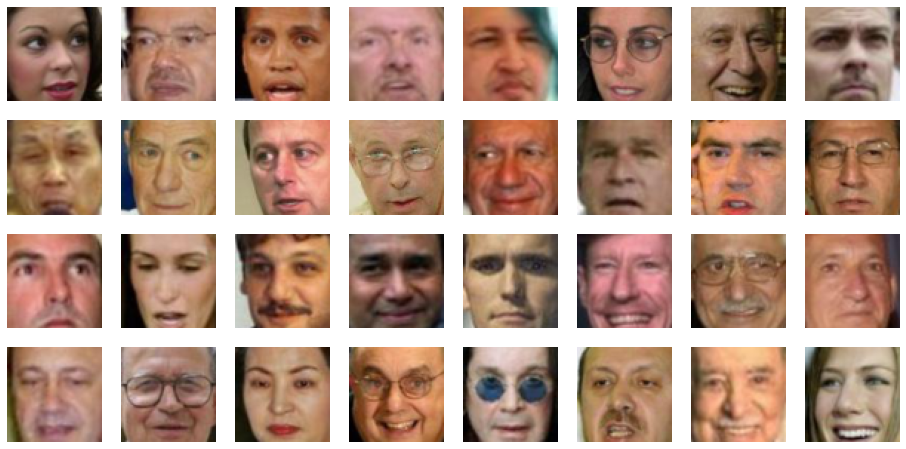

In [10]:
batch = next(iter(dataloader['train']))
show_faces(batch)

## 1.2. Model FC

In [11]:
class AutoencoderFC(torch.nn.Module):
    def __init__(self, dim_code: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=(CHANNELS * IMAGEY * IMAGEX), out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=dim_code),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=(CHANNELS * IMAGEY * IMAGEX)),
        )
        
        
    def forward(self, sample):
        sample = self.flatten(sample).float()
        latent_code = self.encoder(sample)
        reconstructed = self.decoder(latent_code)
        return reconstructed, latent_code

In [12]:
DIM_CODE = 32

autoencoder = AutoencoderFC(dim_code=DIM_CODE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters())
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## 1.3. Train

In [13]:
def train_model(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 20
) -> Dict[str, List[float]]:
    """Training the model. Returns dictionary of train and validation losses.
    Args:
        model (torch.nn.Module): Neural network
        dataloader (Dict[str, DataLoader]):
            Dictionary with 'train' and 'valid' dataloaders
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        epochs (int): Number of training iterations. Default: 20
    """

    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))
            
            #for inputs in tqdm(dataloader[phase], desc=f'Phase {phase}'):
            for inputs in dataloader[phase]:
                inputs = inputs.to(DEVICE)
                # print(inputs.shape)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    outp, _ = model(inputs)
                    outp = outp.view(-1, CHANNELS, IMAGEY, IMAGEX)
                    # print(outp.min())
                    loss = criterion(outp, inputs.float())
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp, _ = model(inputs)
                        outp = outp.view(-1, CHANNELS, IMAGEY, IMAGEX)
                        loss = criterion(outp, inputs.float())
                
                loss_accum.append(loss.item())

            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))
            
            #clear_output(wait=True)
            #show_dermoscopic_imgs(X_val, Y_hat, threshold=0.1)
            #plt.title('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            #plt.show()
    return losses

In [14]:
EPOCH = 100
losses = train_model(autoencoder, dataloader, criterion, optimizer, epochs=EPOCH)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

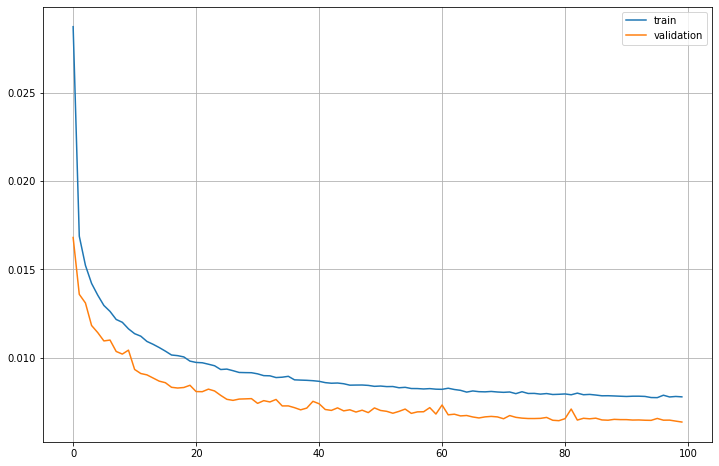

min train loss 0.007737921426274084, min valid loss 0.0063566224693897225


In [15]:
def show_metrics(metrics: Dict[str, List[float]]) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='validation')
    plt.grid()
    plt.legend()
    plt.show()

# look at loss function...
show_metrics(losses)
print('min train loss {}, min valid loss {}'.format(
    min(losses['train']), min(losses['valid'])))

In [16]:
def get_reconstruction(model, batch):
    model.eval()
    with torch.no_grad():
        reconstruction, _ = model(batch.to(DEVICE))
    reconstruction = reconstruction.view(-1, CHANNELS, IMAGEY, IMAGEX)
    reconstruction = reconstruction.cpu().detach()
    return reconstruction

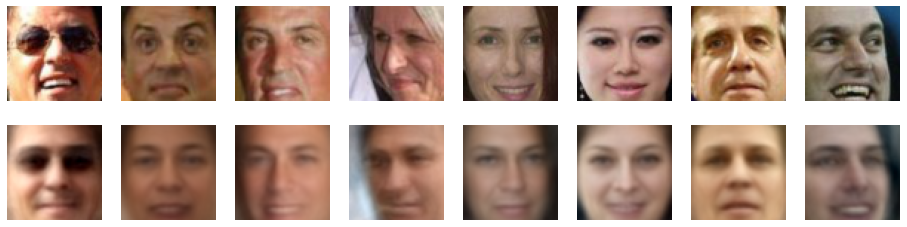

In [17]:
batch = next(iter(dataloader['valid']))
reconstruction = get_reconstruction(autoencoder, batch)
pairs = torch.cat((batch[:8], reconstruction[:8]))
show_faces(pairs, size=(2, 8))

Show results for different hidden dimensions (original + hidden_dim=32, 64, 128, 256, 384, 512)

HIDDEN DIMENSION = 64


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension: 64, min train loss 0.007690614847013274, min valid loss 0.0063292595690914565


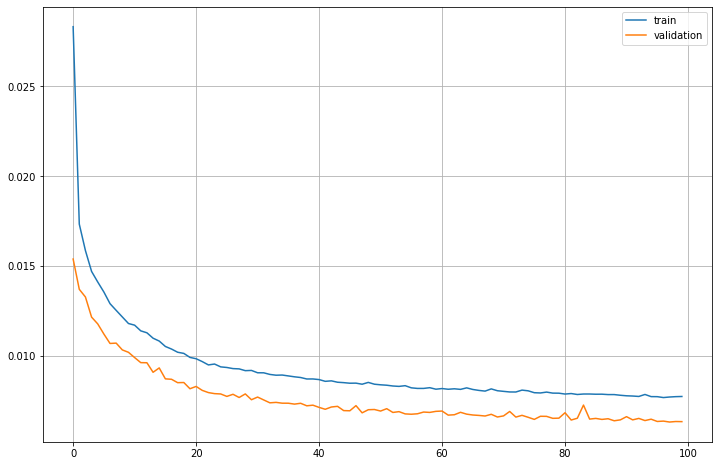

HIDDEN DIMENSION = 128


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension: 128, min train loss 0.007626724205407742, min valid loss 0.00629129595611067


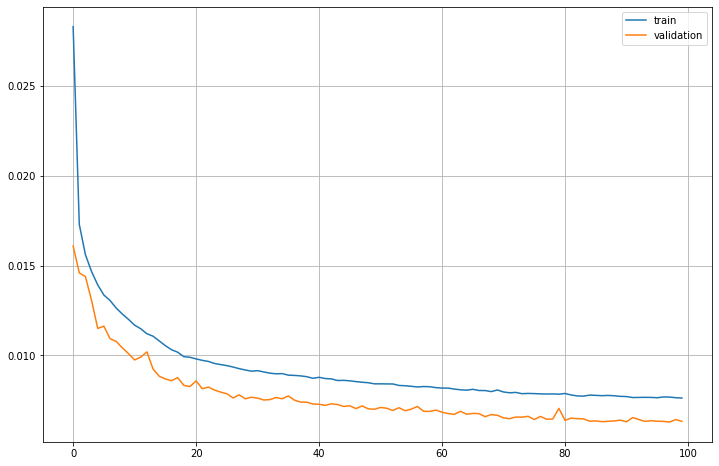

HIDDEN DIMENSION = 256


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension: 256, min train loss 0.007792970249932763, min valid loss 0.006404886643091838


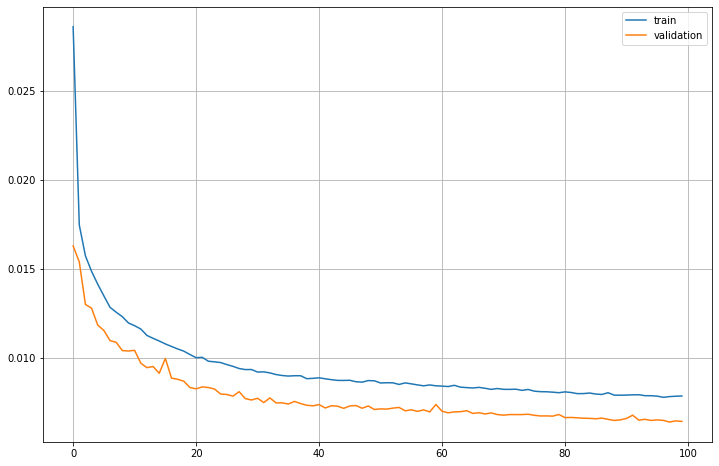

HIDDEN DIMENSION = 384


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension: 384, min train loss 0.007815394560630257, min valid loss 0.006497421723213934


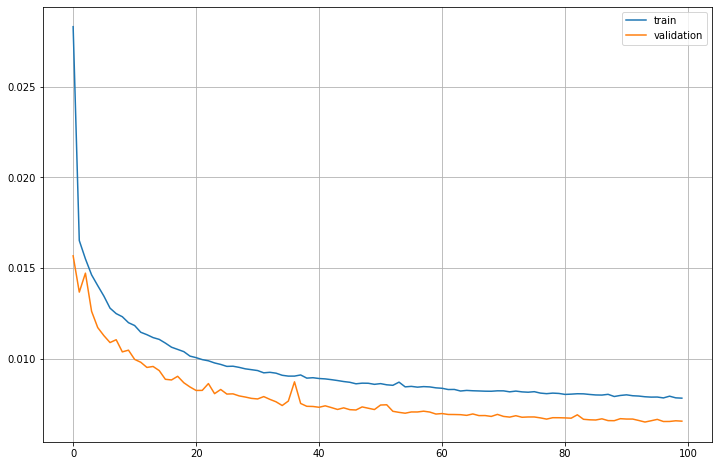

HIDDEN DIMENSION = 512


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension: 512, min train loss 0.007852430442801199, min valid loss 0.006557914040361841


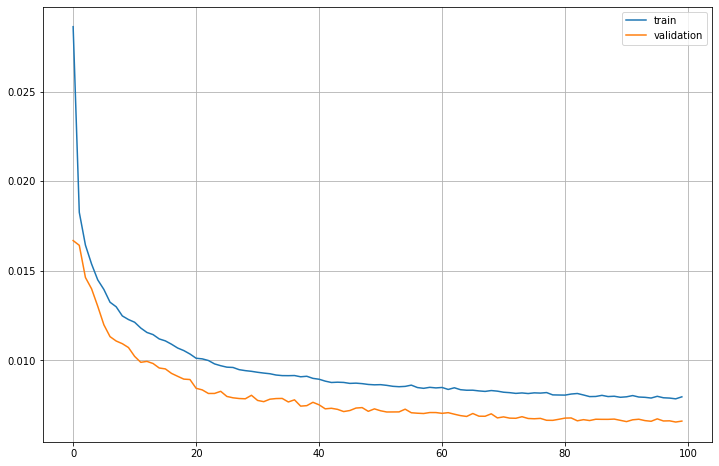

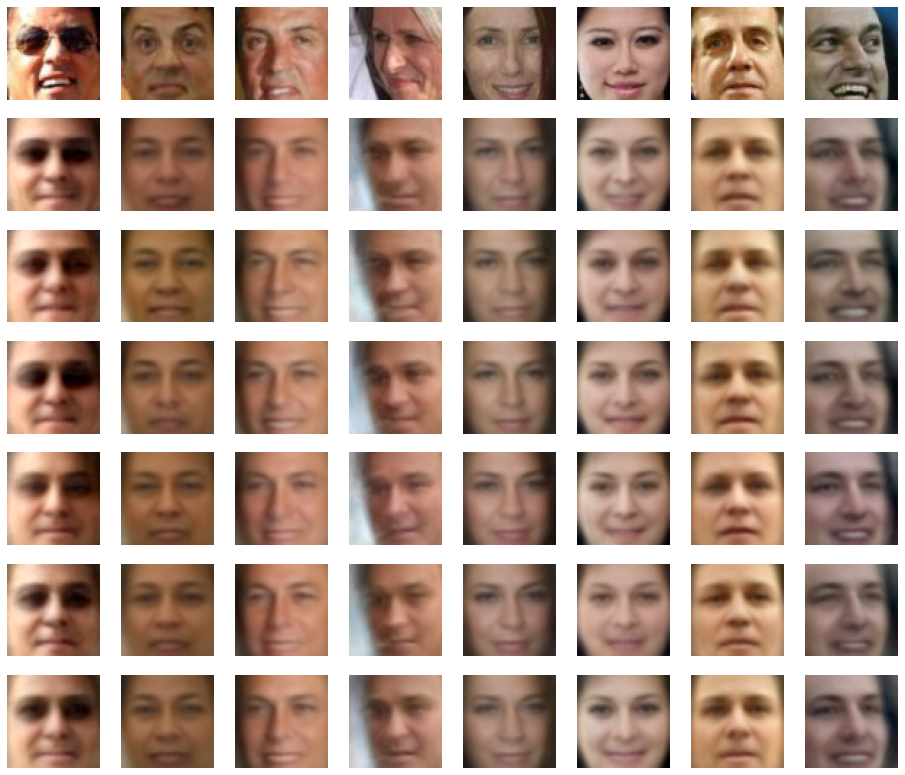

In [18]:
DIM_CODES = [64, 128, 256, 384, 512]
EPOCH = 100
for dim_code in DIM_CODES:
    print(f'HIDDEN DIMENSION = {dim_code}')
    autoencoder = AutoencoderFC(dim_code=dim_code).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters())
    losses = train_model(autoencoder, dataloader, criterion, optimizer, epochs=EPOCH)
    print('Dimension: {}, min train loss {}, min valid loss {}'.format(
        dim_code, min(losses['train']), min(losses['valid'])))
    show_metrics(losses)
    reconstruction = get_reconstruction(autoencoder, batch)
    pairs = torch.cat((pairs, reconstruction[:8]))

show_faces(pairs, size=(len(DIM_CODES) + 2, 8))              

## Model (Conv)

In [19]:
DROPOUT_RATE = 0.5

class AutoencoderConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
 #           nn.BatchNorm2d(128),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        # 16 x 4 x 4
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
#            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),

            
            #nn.ConvTranspose2d(dim_code, 32, kernel_size=7, padding=3),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.ConvTranspose2d(32, 32, kernel_size=7, padding=3),
            #nn.ReLU(),
            #nn.ConvTranspose2d(32, 3, kernel_size=7, padding=3)
        )
        
    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    def latent(self, sample):
        latent = self.encoder(sample)
        return latent
    
    def sample(self, z: torch.Tensor) -> torch.Tensor:
        generated = self.decoder(z)
        return generated

In [20]:
CHANNELS = 3
autoencoder_conv = AutoencoderConv().to(DEVICE)
summary(autoencoder_conv, input_size=(CHANNELS, IMAGEY, IMAGEX))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 16, 16]          36,928
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 128, 8, 8]         147,584
           Conv2d-10            [-1, 256, 8, 8]         295,168
             ReLU-11            [-1, 256, 8, 8]               0
          Dropout-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         295,040
           Conv2d-14             [-1, 1

In [21]:
EPOCH = 100

batch = next(iter(dataloader['valid']))
pairs = batch[:8]

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_conv.parameters())
losses = train_model(
    autoencoder_conv, dataloader, criterion, optimizer, epochs=EPOCH
)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension: 8 x 4 x 4, min train loss 0.0017947259148255595, min valid loss 0.001543170143295789


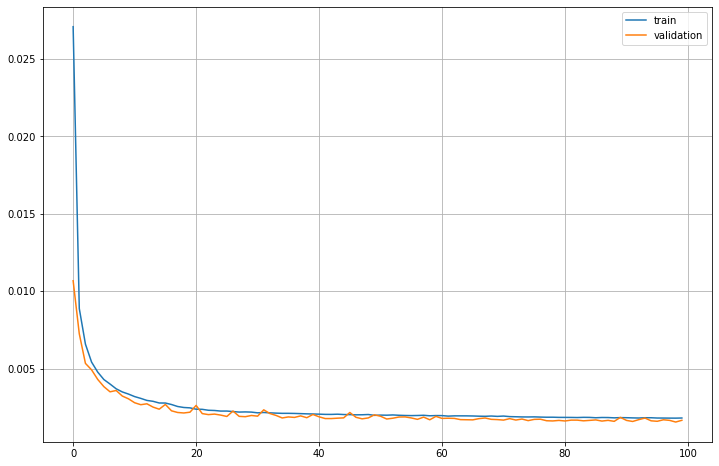

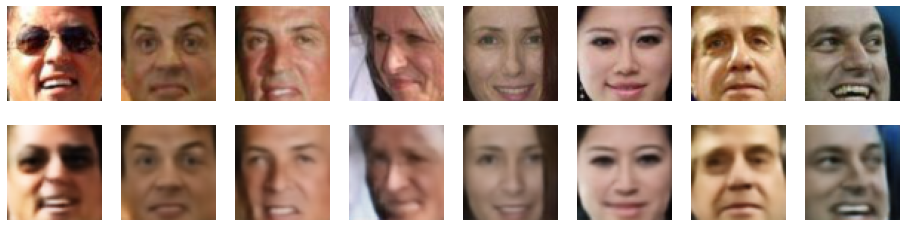

In [22]:
print('Dimension: {}, min train loss {}, min valid loss {}'.format(
    '8 x 4 x 4', min(losses['train']), min(losses['valid'])))
show_metrics(losses)
reconstruction = get_reconstruction(autoencoder_conv, batch)
pairs = torch.cat((pairs, reconstruction[:8]))
show_faces(pairs, size=(2, 8))

## 1.4. Sampling

In [23]:
latents = torch.Tensor()
for inputs in tqdm(dataloader['train']):
    inputs = inputs.to(DEVICE)
    with torch.no_grad():
        latent = autoencoder_conv.latent(inputs).cpu()
        latents = torch.cat((latents, latent))
latents.shape

  0%|          | 0/370 [00:00<?, ?it/s]

torch.Size([11828, 256])

In [24]:
lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)
lat_mean.shape, lat_std.shape

(torch.Size([256]), torch.Size([256]))

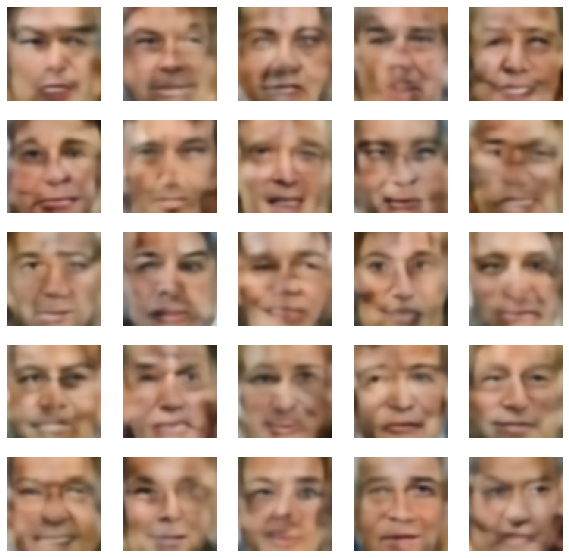

In [25]:
def get_samples(model, batch):
    model.eval()
    with torch.no_grad():
        sample = model.sample(batch.to(DEVICE))
    sample = sample.view(-1, CHANNELS, IMAGEY, IMAGEX)
    sample = sample.cpu().detach()
    return sample

z = torch.FloatTensor(np.random.randn(25, 256))
z = z * lat_std/2 + lat_mean
samples = get_samples(autoencoder_conv, z)
show_faces(samples, size=(5, 5))

## Time to make fun!

Smile
Non smile


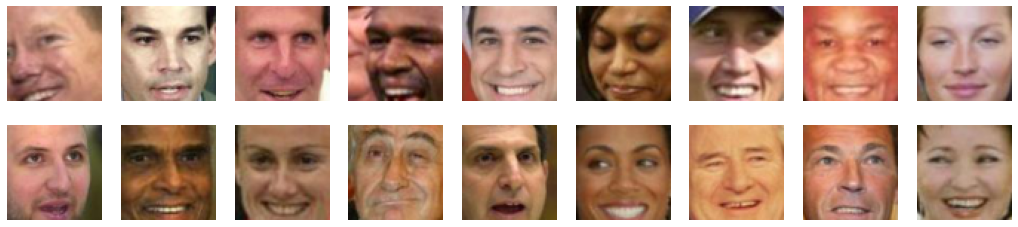

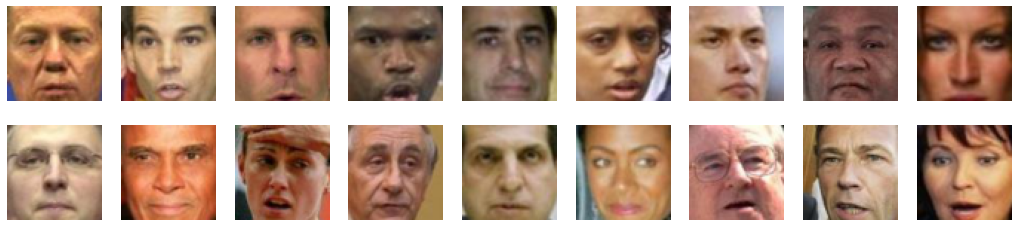

In [26]:
smile = [171, 308, 1433, 1984, 2593, 2816, 3722, 3843, 4623, 4810, 5046, 5071, 5448, 5497, 5619, 6220, 6468, 6842]
non_smile = [170, 307, 1432, 1983, 2594, 2815, 3721, 3844, 4622, 4809, 5047, 5072, 5447, 5496, 5620, 6221, 6467, 6843]
input_smile = torch.Tensor(photos_all[smile])
input_non_smile = torch.Tensor(photos_all[non_smile])
print('Smile')
show_faces(input_smile, size=(2, 9))
print('Non smile')
show_faces(input_non_smile, size=(2, 9))

In [27]:
input_smile = input_smile.to(DEVICE)
input_non_smile = input_non_smile.to(DEVICE)
autoencoder_conv.eval()
with torch.no_grad():
    latent_smile = autoencoder_conv.latent(input_smile).cpu()
    latent_non_smile = autoencoder_conv.latent(input_non_smile).cpu()
smile = latent_smile.mean(dim=0) - latent_non_smile.mean(dim=0)
smile.shape

torch.Size([256])

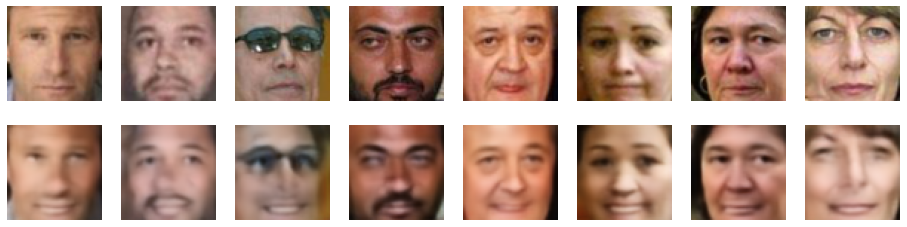

In [28]:
sad_faces = [0, 2, 12, 16, 21, 2112, 2120, 2116]
sad_faces = torch.Tensor(photos_all[sad_faces])
sad_faces = sad_faces.to(DEVICE)
autoencoder_conv.eval()
with torch.no_grad():
    latent_sad = autoencoder_conv.latent(sad_faces).cpu()
    latent_sad_to_smile = (latent_sad + smile).to(DEVICE)
    smile_faces = autoencoder_conv.sample(latent_sad_to_smile)
pairs = torch.cat((sad_faces.cpu(), smile_faces.cpu()))
show_faces(pairs, size=(2, 8))

# 2. Variational Autoencoder

In [29]:
FEATURES = 16
CHANNELS = 3

class LinearVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=(CHANNELS * IMAGEY * IMAGEX), out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=(FEATURES * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=FEATURES, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=(CHANNELS * IMAGEY * IMAGEX)),
        )
        #self.unflatten = nn.Unflatten(-1, (CHANNELS, IMAGEY, IMAGEX))
        
    def get_distribution_params(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, FEATURES)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def sample(self, z: torch.Tensor) -> torch.Tensor:
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, CHANNELS, IMAGEY, IMAGEX)
        return generated
    
    def forward(
        self, x: torch.Tensor
        ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        mu, log_var = self.get_distribution_params(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.sample(z)
        #x = self.decoder(z)
        #x = torch.sigmoid(x)
        #reconstruction = x.view(-1, CHANNELS, IMAGEY, IMAGEX)
        return reconstruction, mu, log_var

    def get_latent_vector(self, x: torch.Tensor):
        mu, log_var = self.get_distribution_params(x)
        z = self.reparameterize(mu, log_var)
        return z

## Loss

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$
$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

In [30]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu: torch.Tensor, log_var: torch.Tensor):
        return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

In [31]:
class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_divergence = KLDivergenceLoss()
        self.log_likelihood = nn.BCELoss(reduction='sum')

    def forward(self,
        mu: torch.Tensor,
        log_var: torch.Tensor,
        outputs: torch.Tensor,
        labels: torch.Tensor
    ) -> torch.Tensor:
        #print(self.kl_divergence(mu, log_var), self.log_likelihood(outputs, labels))
        return self.kl_divergence(mu, log_var) + self.log_likelihood(outputs, labels)

In [32]:
autoencoder_vae = LinearVAE().to(DEVICE)
criterion = VAELoss()
optimizer = torch.optim.Adam(autoencoder_vae.parameters())

In [33]:
def train_model(
    model: nn.Module,
    dataloader: Dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: nn.Module,
    epochs: int = 25
) -> Dict[str, List[float]]:
    """Training the model. Returns dictionary of train and validation losses.
    Args:
        model (torch.nn.Module): Neural network
        dataloader (Dict[str, DataLoader]):
            Dictionary with 'train' and 'valid' dataloaders
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        epochs (int): Number of training iterations. Default: 50
    """

    losses = {'train': [], 'valid': []}
    progress = tqdm(range(epochs), desc='Epoch')
    
    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = []
            model.train(mode=(phase == 'train'))
            
            #for inputs in tqdm(dataloader[phase], desc=f'Phase {phase}'):
            for inputs in dataloader[phase]:
                inputs = inputs.to(DEVICE)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    outp, mu, log_var = model(inputs)
                    #outp = outp.view(-1, IMAGEX, IMAGEY, CHANNELS)
                    loss = criterion(mu, log_var, outp, inputs.float())
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp, mu, log_var = model(inputs)
                        #outp = outp.view(-1, IMAGEX, IMAGEY, CHANNELS)
                        loss = criterion(mu, log_var, outp, inputs.float())
                
                loss_accum.append(loss.item())

#                 fig,ax = plt.subplots(5,5)
#                 for ax, img in zip(ax.flatten(), outp.cpu().detach().numpy()):
#                     ax.imshow(img)
#                 plt.show()

            phase_loss = np.mean(loss_accum)
            losses[phase].append(phase_loss)
            progress.set_description('loss: {:.4f}'.format(phase_loss))

    return losses

In [34]:
losses = train_model(autoencoder_vae, dataloader, criterion, optimizer, epochs=50)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

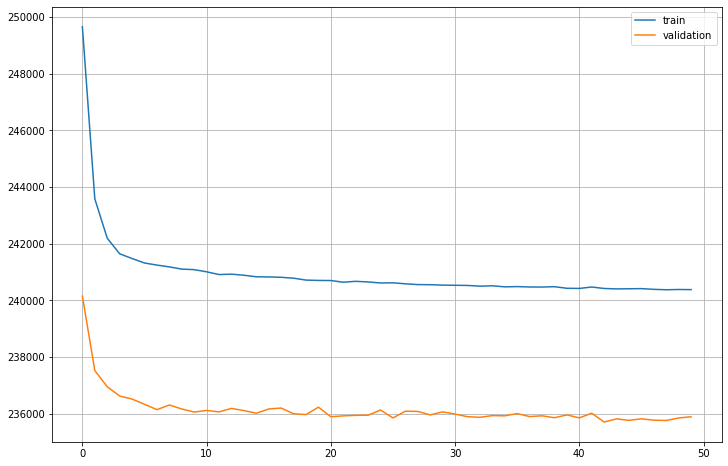

In [35]:
show_metrics(losses)

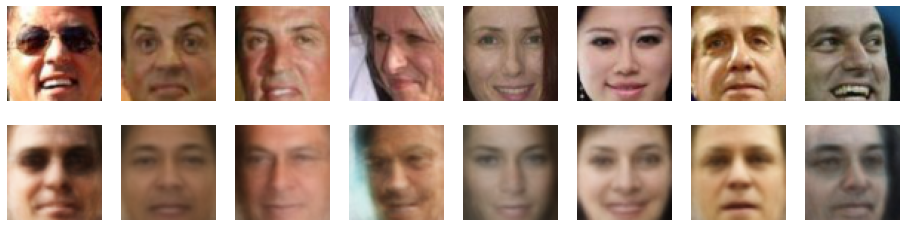

In [36]:
batch = next(iter(dataloader['valid']))
autoencoder_vae.eval()
with torch.no_grad():
    reconstruction, mu, log_var = autoencoder_vae(batch.to(DEVICE))
pairs = torch.cat((batch[:8].cpu(), reconstruction[:8].cpu()))
show_faces(pairs, size=(2, 8))

## Sampling

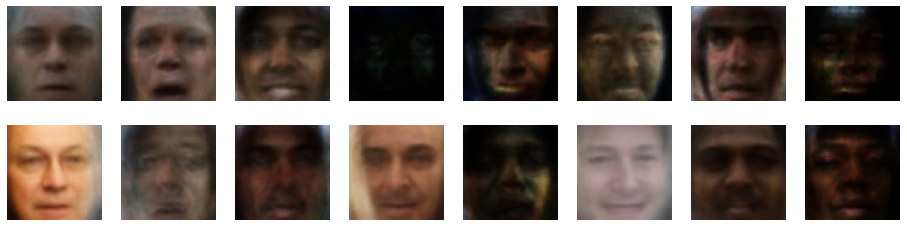

In [37]:
z = np.array([np.random.normal(0, 1, 16) for i in range(16)])
output = autoencoder_vae.sample(torch.FloatTensor(z).to(DEVICE))
show_faces(output.cpu().detach(), size=(2, 8))

## Latent vectors

$$\alpha l_1 + (1 - \alpha)l_2$$
$$where l_1, l_2 – latent vectors, \alpha \in [0, 1]$$

In [38]:
gt_0 = batch[0][None,:,:,:].to(DEVICE)
gt_1 = batch[2][None,:,:,:].to(DEVICE)
first_latent_vector = autoencoder_vae.get_latent_vector(gt_0)
second_latent_vector = autoencoder_vae.get_latent_vector(gt_1)

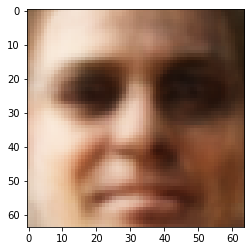

In [39]:
plt.imshow(autoencoder_vae.sample(first_latent_vector)[0].cpu().detach().numpy().transpose(1, 2, 0))

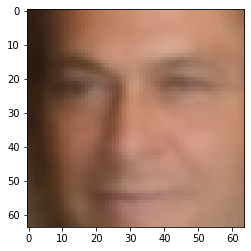

In [40]:
plt.imshow(autoencoder_vae.sample(second_latent_vector)[0].cpu().detach().numpy().transpose(1, 2, 0))

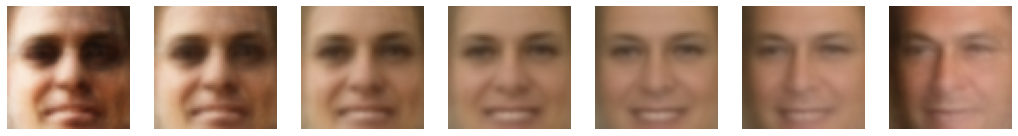

In [41]:
plt.figure(figsize=(18, 5))
for i, alpha in enumerate(np.linspace(0., 1., 7)):
    plt.subplot(1, 7, i + 1)
    latent = (1 - alpha) * first_latent_vector + alpha * second_latent_vector
    img = autoencoder_vae.sample(latent)[0].cpu().detach().numpy().transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(img)